In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import numpy
import scipy
import scipy.constants
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import os
import sys
import json
import subprocess
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
#
# system_name='mazama'
system_name='Sherlock_Owners'
groups_fname=None

#groups_fname='mazama_groups.json'
#
#data_file_name='data/sacct_mazama_out_2.out'
#data_file_name = 'data/mazama_usage_20200506_tool8.out'
#data_file_name = 'data/sacct_mazama_out_20200506a.out'
#data_file_name = 'data/sacct_serc_20200622.out'
#data_file_name = 'data/sacct_serc_20200622.out'
data_file_name = 'data/sacct_owners_out_3500489.out'
#
# as small(ish) test data set:
#data_file_name = 'data/sacct_mazama_20200701_20200718.out'

#data_file_name = 'data/serc_sacct_2020_06_29.out'

output_path = 'output/{}_HPC_analytics'.format(system_name)
#output_path = 'output/HPC_analytics'

In [6]:
load_pickle = True
dump_pickle = True
max_rows = None
#max_rows = 1000
n_cpu=4
pkl_name = "{}.pkl".format(os.path.splitext(data_file_name)[0])
#
if load_pickle:
    with open(pkl_name, 'rb') as fin:
        sacct_obj=pickle.load(fin)
    #
else:
    sacct_obj = hpc_lib.SACCT_data_handler(data_file_name=data_file_name,
                    max_rows=max_rows, n_cpu=n_cpu, verbose=1)
    #
    if dump_pickle:
        with open(pkl_name, 'wb') as fout:
                #out_pkl = pickle.dump(sacct_demo.jobs_summary, fout)
                out_pkl = pickle.dump(sacct_obj, fout)
#

In [7]:
print("States: ", [s for s in set(sacct_obj.jobs_summary['State']) if not "CANCELLED" in s] )
#
#dT = .5
ix_pr  = sacct_obj.jobs_summary['State']=='PREEMPTED'
ix_npr = sacct_obj.jobs_summary['State']!='PREEMPTED'
ix_cpl = sacct_obj.jobs_summary['State']=='COMPLETED'
#
#
N_pr  = numpy.sum(ix_pr)
N_npr = numpy.sum(ix_npr)
N_cpl = numpy.sum(ix_cpl)
print('*** preempted: {} vs {}, a/b={}, {}'.format(N_pr, N_npr, N_pr/N_npr, N_pr/(N_pr + N_cpl)))


States:  ['REQUEUED', 'TIMEOUT', 'COMPLETED', 'PREEMPTED', 'RUNNING', 'OUT_OF_MEMORY', 'PENDING', 'FAILED', 'NODE_FAIL']
*** preempted: 80966 vs 3920991, a/b=0.020649371549182338, 0.02604270867843691


In [8]:
print('** ', sacct_obj.data.dtype.names)
#print('** ', [s for s in set(sacct_objmazama.data['State']) if 'PR' in s])
#
preempted = (sacct_obj.jobs_summary[['JobID', 'NCPUS', 'NNodes', 'Submit', 'Start',
                              'End', 'Elapsed']][ix_pr])
preempted = preempted[numpy.argsort(preempted['JobID'])]
#
print('*** len: ', len(preempted))

#jsp = sacct_obj.

#print('** ', preempted[numpy.argsort(preempted['JobID'])][0:10])
#print('** ', preempted[0:10])
#pr_working = preempted[['JobID', 'NCPUS', 'NNodes', 'Submit', 'Start',
#                              'End', 'Elapsed']]
#
compl = sacct_obj.jobs_summary[['JobID', 'NCPUS', 'NNodes', 'Submit', 'Start',
                              'End', 'Elapsed']][ix_npr]

#compl = sacct_obj.jobs_summary[['JobID', 'NCPUS', 'NNodes', 'Submit', 'Start',
#                              'End', 'Elapsed']][sacct_obj.jobs_summary['State']!='PREEMPTED']

print(preempted[0:10])
print('** ', preempted.dtype.names)
#
print('** len(completed): ', len(compl))



**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqGRES', 'AllocGRES', 'ReqTRES', 'AllocTRES', 'JobID_parent')
*** len:  80966
[('1002304', 1, 1, 737567.485     , 737567.49084491, 737567.50112269, 0.01021991)
 ('1003246_420', 1, 1, 737567.50872685, 737567.51943287, 737567.52925926, 0.00976852)
 ('1003246_421', 1, 1, 737567.50872685, 737567.51943287, 737567.52943287, 0.0099537 )
 ('1003246_426', 1, 1, 737567.50872685, 737567.51943287, 737567.52365741, 0.00418981)
 ('1003246_427', 1, 1, 737567.50872685, 737567.51943287, 737567.52365741, 0.00418981)
 ('1003246_428', 1, 1, 737567.50872685, 737567.51943287, 737567.52365741, 0.00418981)
 ('1003246_429', 1, 1, 737567.50872685, 737567.51943287, 737567.52365741, 0.00418981)
 ('1003246_430', 1, 1, 737567.50872685, 737567.51943287, 737567.52365741, 0.

### Preemption probabilities
- As a function of time
- Elapsed runtime, preceding preemption
- Count number $N(<t)$ for jobs that are (not) preempted, $P=N_p(t)/N_c(t)$

Preempted: t_90: 11.1631
Preempted: P(1hr): 0.6155485018402787
Completed: t_90: 6.03662986111111
Completed: P(1hr): 0.755282784377725
** N_completed: 3920991
** N_pr: 80966
** P(re):  0.020231601688873717
***  49.278611111111104
** **  (2, 49)
*** ***
[0.72825955 0.79778096 0.83275419 0.85155468 0.86856202 0.87917019
 0.89008296 0.89557982 0.90150873 0.90610477 0.91158215 0.91503349
 0.91864676 0.92064655 0.92249291 0.92434927 0.92626011 0.92784785
 0.92924418 0.9307577 ]
[0.74049893 0.81210984 0.8480686  0.86754626 0.88505986 0.89608708
 0.90733468 0.9131384  0.91933068 0.92413188 0.92978567 0.93338169
 0.93716388 0.9393041  0.9412854  0.94327895 0.94529098 0.94698492
 0.94850669 0.95010418]


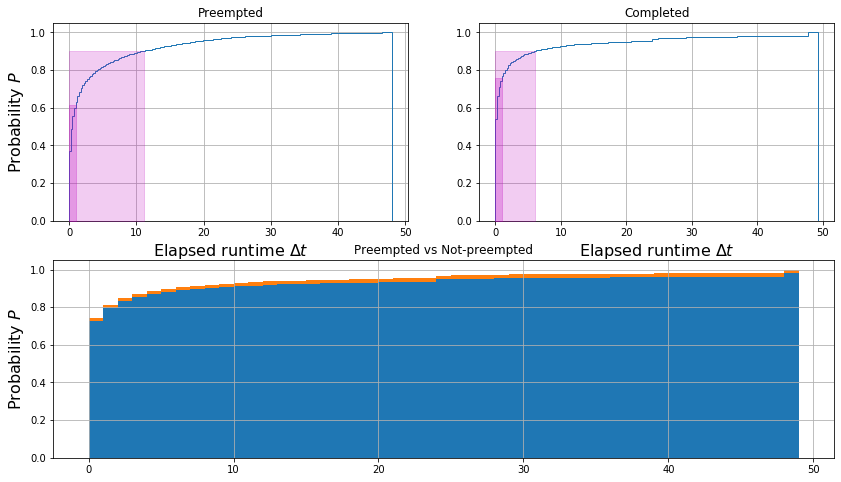

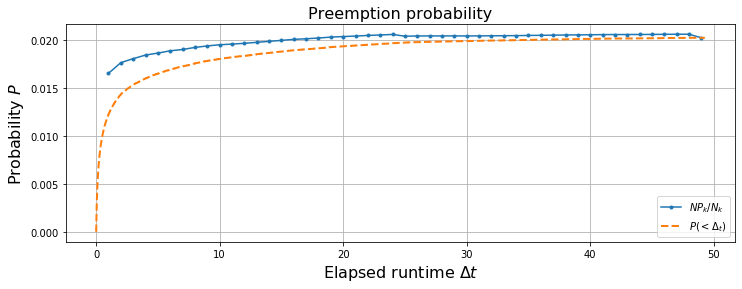

In [9]:
fg = plt.figure(figsize=(14,8))
ax1 = fg.add_subplot('221')
ax2 = fg.add_subplot('222')
ax3 = fg.add_subplot('212')
#
ax1.set_ylabel('Probability $P$', size=16)
ax3.set_ylabel('Probability $P$', size=16)
ax1.set_xlabel('Elapsed runtime $\Delta t$', size=16)
ax2.set_xlabel('Elapsed runtime $\Delta t$', size=16)
#
hhs=[]

for nm, dta,ax in [("Preempted", preempted, ax1), ("Completed", compl, ax2)]:
    hh = ax.hist(dta['Elapsed']*24., bins=200, cumulative=True,
                  density=True, zorder=5, histtype='step')
    hhs+=[hh]
    #
    y_90=.9*numpy.max(hh[0])
    k_90=numpy.searchsorted(hh[0], y_90)
    #x_90 = .5*(hh[1][k_90]+hh[1][k_90+1])
    x_90 = numpy.mean(hh[1][k_90:k_90+2])
    ax.fill_between([0., x_90], [0.,0.], y_90, color='m', alpha=.2, zorder=11)
    #
    # 1 hour:
    dt=1.
    k1h = numpy.searchsorted(hh[1], dt)
    y1h = numpy.mean(hh[0][k1h-2:k1h])
    ax.fill_between([0., 1.], 0., y1h, color='m', alpha=.25, zorder=10 )

    ax.grid()
    ax.set_title("{}".format(nm))
    #
    print('{}: t_90: {}'.format(nm, x_90))
    print('{}: P(1hr): {}'.format(nm, y1h/numpy.max(hh[0])))
    #
print('** N_completed: {}'.format(len(compl)))
print('** N_pr: {}'.format(len(preempted)))
#
print('** P(re): ', len(preempted)/(len(preempted)+len(compl)))
#
# TODO: total probability distribution of preemption. so basically we want to add the cumulative histograms
#. of preempted and completed.To do that, we have to interpolate the two sets on to the same x-axis.
# a quick estimator is to just multiply by P(preempt).
#ax3.plot()
#print('** ', type(hh[0]))
max_bin = numpy.max([numpy.max(preempted['Elapsed']), numpy.max(compl['Elapsed'])])*24
print('*** ', max_bin)
bins = numpy.arange(0., max_bin,1.)
hhh = ax3.hist([compl['Elapsed']*24., preempted['Elapsed']*24.], bins=bins,
              histtype='barstacked', density=True, log=False, cumulative=True,
               bottom=0.0*numpy.ones(-1+len(bins)))
ax3.grid()
ax3.set_title('Preempted vs Not-preempted')
#
print('** ** ', numpy.shape(hhh[0]))
# note: if we're using the "barstacked" histogram, the second series is S2 = s1+s2.
#
P_pr=1.- (hhh[0][0]/hhh[0][1])
#
fg2=plt.figure(figsize=(12,4))
ax4 = fg2.add_subplot('111')
ax4.set_title('Preemption probability', size=16)
ax4.set_ylabel('Probability $P$', size=16)
ax4.set_xlabel('Elapsed runtime $\Delta t$', size=16)

#ax4a = ax4.twinx()
#
ax4.plot(hhh[1][1:], P_pr, ls='-', marker='.', label='$NP_k/N_k$')
# ax4.plot(bins[1:], hhh[0][0])
# ax4a.plot(bins[1:], hhh[0][1])
ax4.grid()
#
# let's just build this cum-prob manually:
dt_Np = numpy.zeros( (len(sacct_obj.jobs_summary),2))
#for t,s in sacct_obj.jobs_summary[numpy.argsort(sacct_mazama.jobs_summary['Elapsed'])]:
#    it s=='PREEMPTED'

ix_s = numpy.argsort(sacct_obj.jobs_summary['Elapsed'])
dt_Np[:,0] = sacct_obj.jobs_summary['Elapsed'][ix_s]
dt_Np[:,1] = numpy.cumsum((sacct_obj.jobs_summary['State'][ix_s]=='PREEMPTED').astype(int))
#
# /float(len(dt_Np))
ax4.plot(dt_Np[:,0]*24., dt_Np[:,1]/float(len(dt_Np)), ls='--', lw=2., label='$P(<\Delta_t)$')
#
# the hist and just counting cumulative measures match, if they're not normalized. just using the top
# of the stacked histogram doesnot seem to work quite right... because they are slightly different measures
# of the probability of PreEmption. gotta think about that a bit...
#hh = ax4.hist(preempted['Elapsed']*24., bins=100, cumulative=True,
#                  density=False, zorder=5, histtype='step')
ax4.legend(loc=0)
#
print('*** ***')
print(hhh[0][0][0:20])
print(hhh[0][1][0:20])

### Preemption prorabilities (total CPU time):
- Same as above, but compute as a function of totalcput time, not just elapsed.

In [10]:
print('*** ', sacct_obj.jobs_summary.dtype.names)

***  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqGRES', 'AllocGRES', 'ReqTRES', 'AllocTRES', 'JobID_parent')


Preempted: t_90: 18.231
Preempted: P(1hr): nan


/share/cees/software/anaconda/3.7.6/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/share/cees/software/anaconda/3.7.6/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Completed: t_90: 19.202333333333332
Completed: P(1hr): nan
** N_completed: 3920991
** N_pr: 80966
** P(re):  0.020231601688873717
***  49.278611111111104
** **  (2, 49)
*** ***
[0.72825955 0.79778096 0.83275419 0.85155468 0.86856202 0.87917019
 0.89008296 0.89557982 0.90150873 0.90610477 0.91158215 0.91503349
 0.91864676 0.92064655 0.92249291 0.92434927 0.92626011 0.92784785
 0.92924418 0.9307577 ]
[0.74049893 0.81210984 0.8480686  0.86754626 0.88505986 0.89608708
 0.90733468 0.9131384  0.91933068 0.92413188 0.92978567 0.93338169
 0.93716388 0.9393041  0.9412854  0.94327895 0.94529098 0.94698492
 0.94850669 0.95010418]
*** Np/(Nc + Np)= 0.02604270867843691
*** Np/Nc= 0.020231601688873717


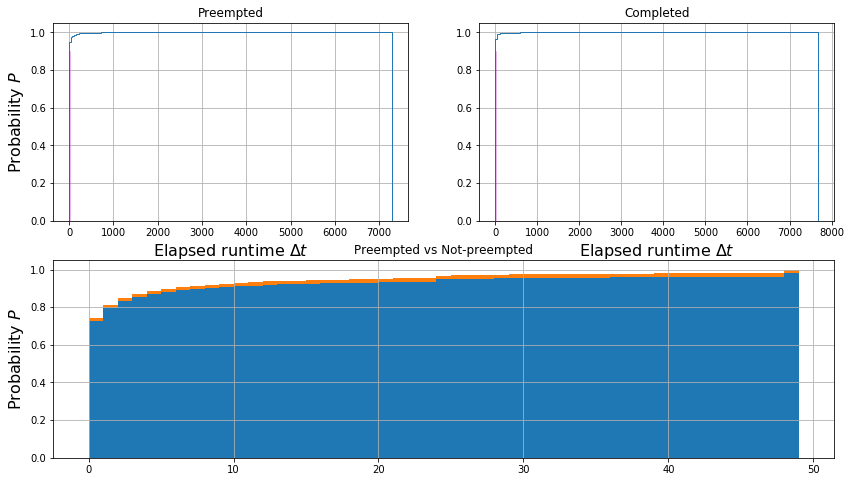

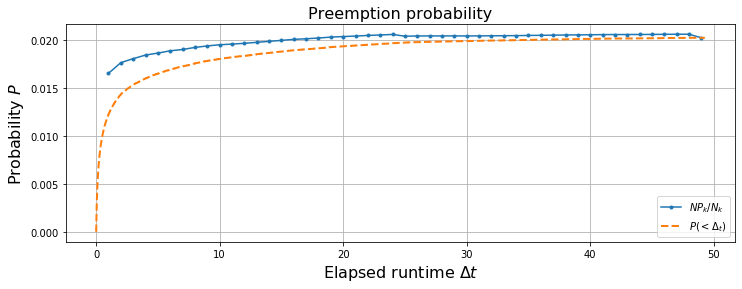

In [11]:
fg = plt.figure(figsize=(14,8))
ax1 = fg.add_subplot('221')
ax2 = fg.add_subplot('222')
ax3 = fg.add_subplot('212')
#
ax1.set_ylabel('Probability $P$', size=16)
ax3.set_ylabel('Probability $P$', size=16)
ax1.set_xlabel('Elapsed runtime $\Delta t$', size=16)
ax2.set_xlabel('Elapsed runtime $\Delta t$', size=16)
#
hhs=[]

for nm, dta,ax in [("Preempted", preempted, ax1), ("Completed", compl, ax2)]:
    # NOTE: TotalCPU, UserCPU, and SystemCPU -- until recently, were recorded as strings.
    #. they should the esame type as Elapsed, so we've replaced the processor function
    #. to convert them to float. BUT, until then, use Elapsed*NCPUS.
    #
    hh = ax.hist(dta['Elapsed']*dta['NCPUS']*24., bins=200, cumulative=True,
                  density=True, zorder=5, histtype='step')
    hhs+=[hh]
    #
    y_90=.9*numpy.max(hh[0])
    k_90=numpy.searchsorted(hh[0], y_90)
    #x_90 = .5*(hh[1][k_90]+hh[1][k_90+1])
    x_90 = numpy.mean(hh[1][k_90:k_90+2])
    ax.fill_between([0., x_90], [0.,0.], y_90, color='m', alpha=.2, zorder=11)
    #
    # 1 hour:
    dt=1.
    k1h = numpy.searchsorted(hh[1], dt)
    y1h = numpy.mean(hh[0][k1h-2:k1h])
    ax.fill_between([0., 1.], 0., y1h, color='m', alpha=.25, zorder=10 )

    ax.grid()
    ax.set_title("{}".format(nm))
    #
    print('{}: t_90: {}'.format(nm, x_90))
    print('{}: P(1hr): {}'.format(nm, y1h/numpy.max(hh[0])))
    #
print('** N_completed: {}'.format(len(compl)))
print('** N_pr: {}'.format(len(preempted)))
#
print('** P(re): ', len(preempted)/(len(preempted)+len(compl)))
#
# TODO: total probability distribution of preemption. so basically we want to add the cumulative histograms
#. of preempted and completed.To do that, we have to interpolate the two sets on to the same x-axis.
# a quick estimator is to just multiply by P(preempt).
#ax3.plot()
#print('** ', type(hh[0]))
max_bin = numpy.max([numpy.max(preempted['Elapsed']), numpy.max(compl['Elapsed'])])*24
print('*** ', max_bin)
bins = numpy.arange(0., max_bin,1.)
hhh = ax3.hist([compl['Elapsed']*24., preempted['Elapsed']*24.], bins=bins,
              histtype='barstacked', density=True, log=False, cumulative=True,
               bottom=0.0*numpy.ones(-1+len(bins)))
ax3.grid()
ax3.set_title('Preempted vs Not-preempted')
#
print('** ** ', numpy.shape(hhh[0]))
# note: if we're using the "barstacked" histogram, the second series is S2 = s1+s2.
#
P_pr=1.- (hhh[0][0]/hhh[0][1])
#
fg2=plt.figure(figsize=(12,4))
ax4 = fg2.add_subplot('111')
ax4.set_title('Preemption probability', size=16)
ax4.set_ylabel('Probability $P$', size=16)
ax4.set_xlabel('Elapsed runtime $\Delta t$', size=16)

#ax4a = ax4.twinx()
#
ax4.plot(hhh[1][1:], P_pr, ls='-', marker='.', label='$NP_k/N_k$')
# ax4.plot(bins[1:], hhh[0][0])
# ax4a.plot(bins[1:], hhh[0][1])
ax4.grid()
#
# let's just build this cum-prob manually:
dt_Np = numpy.zeros( (len(sacct_obj.jobs_summary),2))
#for t,s in sacct_obj.jobs_summary[numpy.argsort(sacct_mazama.jobs_summary['Elapsed'])]:
#    it s=='PREEMPTED'

ix_s = numpy.argsort(sacct_obj.jobs_summary['Elapsed'])
dt_Np[:,0] = sacct_obj.jobs_summary['Elapsed'][ix_s]
dt_Np[:,1] = numpy.cumsum((sacct_obj.jobs_summary['State'][ix_s]=='PREEMPTED').astype(int))
#
# /float(len(dt_Np))
ax4.plot(dt_Np[:,0]*24., dt_Np[:,1]/float(len(dt_Np)), ls='--', lw=2., label='$P(<\Delta_t)$')
#
# the hist and just counting cumulative measures match, if they're not normalized. just using the top
# of the stacked histogram doesnot seem to work quite right... because they are slightly different measures
# of the probability of PreEmption. gotta think about that a bit...
#hh = ax4.hist(preempted['Elapsed']*24., bins=100, cumulative=True,
#                  density=False, zorder=5, histtype='step')
ax4.legend(loc=0)
#
print('*** ***')
print(hhh[0][0][0:20])
print(hhh[0][1][0:20])
#



tmp_Np = numpy.sum((sacct_obj.jobs_summary['State'][ix_s]=='PREEMPTED').astype(int))
tmp_Nc = numpy.sum((sacct_obj.jobs_summary['State'][ix_s]=='COMPLETED').astype(int))
Np_Nc = tmp_Np/(tmp_Nc+tmp_Np)
Np_T  = tmp_Np/len(sacct_obj.jobs_summary)
print('*** Np/(Nc + Np)=', Np_Nc)
print('*** Np/Nc=', Np_T)

In [12]:
wait_stats = sacct_obj.get_wait_stats()

/scratch/myoder96/HPC_analytics/hpc_lib.py:919: RuntimeWarning: invalid value encountered in greater_equal
  x_prime = delta_ts[numpy.logical_and(self.jobs_summary['NCPUS']==k, delta_ts>=0.)]


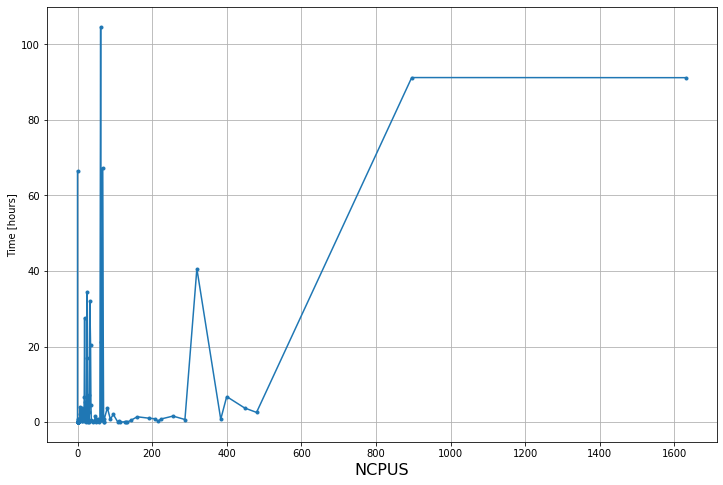

In [13]:
fg = plt.figure(figsize=(12,8))
ax1 = plt.subplot('111')
ax1.grid()
ax1.set_xlabel('NCPUS', size=16)
ax1.set_ylabel('Time [hours]')
#
ix = numpy.argsort(wait_stats['ncpus'])
ax1.plot(wait_stats['ncpus'][ix], 24.*wait_stats['median'][ix], ls='-', marker='.')

/home/myoder96/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'time $t$ [hours]')

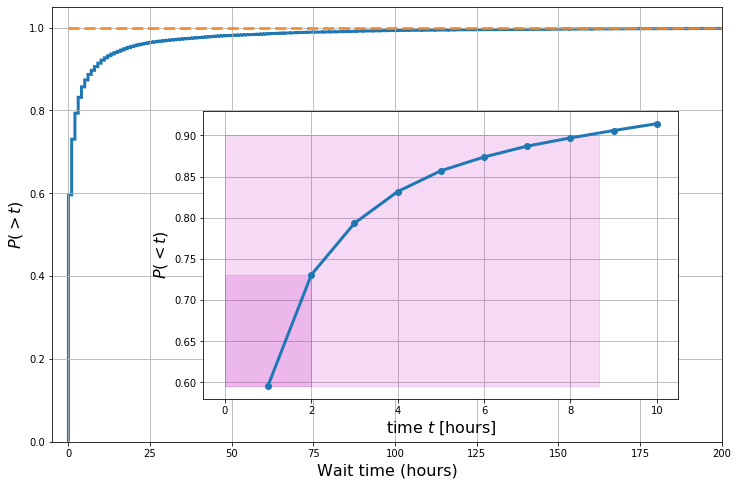

In [14]:
#
delta_ts = 24.*(sacct_obj.jobs_summary['Start'] - sacct_obj.jobs_summary['Submit'])
ix = delta_ts>=0
#
fg = plt.figure(figsize=(12,8))
ax1 = plt.subplot('111')
ax1.grid()
#
ax2 = fg.add_axes([.3, .2, .55, .5])
ax2.grid()
#
hh = ax1.hist(delta_ts[ix], bins=numpy.arange(0., max(delta_ts[ix]), 1), density=True,
              cumulative=True, histtype='step', lw=3.0)
#
q_90=.9
k_90 = numpy.searchsorted(hh[0], q_90)
#print('*** k90: ', k_90)
x_90 = (hh[1][k_90]*(q_90-hh[0][k_90-1]) + hh[1][k_90+1]*(hh[0][k_90]-q_90))/(hh[0][k_90]-hh[0][k_90-1])

ax1.plot([min([ix][0]), max(delta_ts[ix])], [1., 1.], ls='--', lw=3., alpha=.8)
#
#ax1.set_ylim(.8,1.02)
ax1.set_xlim(-5, 200)
ax1.set_xlabel('Wait time (hours)', size=16)
ax1.set_ylabel('$P(>t)$', size=16)
#
ax2.plot(hh[1][1:11], hh[0][0:10], marker='o', ls='-', lw=3., zorder=12)
ax2.fill_between(hh[1][0:3], numpy.ones(3)*hh[0][1], hh[0][0],
                 color='m', alpha=.15, zorder=11)
#
ax2.fill_between([0,x_90], numpy.ones(2)*q_90, hh[0][0],
                 color='m', alpha=.15, zorder=11)
#
ax2.set_ylabel('$P(<t)$', size=16)
ax2.set_xlabel('time $t$ [hours]', size=16)

In [15]:
ix_h = numpy.where(numpy.invert(numpy.isnan(delta_ts)))
mean_waits   = numpy.mean(delta_ts[ix_h])
median_waits = numpy.median(delta_ts[ix_h])
std_waits    = numpy.std(delta_ts[ix_h])
print('*** mean, median: ', mean_waits, median_waits, std_waits)

*** mean, median:  4.690513389554864 0.6294444445520639 18.762154990188137


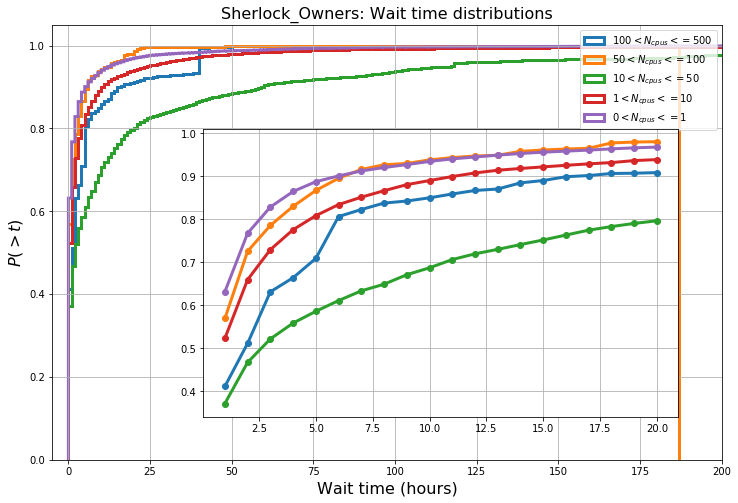

In [16]:
# break out wait times by ncpus:
#
#delta_ts = 24.*(sacct_obj.jobs_summary['Start'] - sacct_obj.jobs_summary['Submit'])
#ix = delta_ts>=0
#
fg = plt.figure(figsize=(12,8))
ax1 = plt.subplot('111')
ax1.grid()
#
ax2 = fg.add_axes([.3, .2, .55, .5])
ax2.grid()
n_ax2 = 20
#
for k2, k1 in [(500,100), (100,50), (50,10), (10,1), (1,0)]:
    #
    X = delta_ts[numpy.logical_and(ix,
                    numpy.logical_and(sacct_obj.jobs_summary['NCPUS']>k1,
                                      sacct_obj.jobs_summary['NCPUS']<=k2))]
    hh = ax1.hist(X, bins=numpy.arange(0., max(X), 1), density=True,
                  cumulative=True, histtype='step', lw=3.0, label='${} < N_{{cpus}} <= {}$'.format(k1, k2))
    
    ax2.plot(hh[1][1:n_ax2+1], hh[0][0:n_ax2], marker='o', ls='-', lw=3., zorder=12)
#
# q_90=.9
# k_90 = numpy.searchsorted(hh[0], q_90)
# #print('*** k90: ', k_90)
# x_90 = (hh[1][k_90]*(q_90-hh[0][k_90-1]) + hh[1][k_90+1]*(hh[0][k_90]-q_90))/(hh[0][k_90]-hh[0][k_90-1])

# ax1.plot([min([ix][0]), max(delta_ts[ix])], [1., 1.], ls='--', lw=3., alpha=.8)
#
#ax1.set_ylim(.8,1.02)
ax1.set_xlim(-5, 200)
ax1.set_xlabel('Wait time (hours)', size=16)
ax1.set_ylabel('$P(>t)$', size=16)
ax1.set_title('{}: Wait time distributions'.format(system_name), size=16)
ax1.legend(loc=0)
#
#ax2.plot(hh[1][1:11], hh[0][0:10], marker='o', ls='-', lw=3., zorder=12)
#ax2.fill_between(hh[1][0:3], numpy.ones(3)*hh[0][1], hh[0][0],
#                 color='m', alpha=.15, zorder=11)
#
#ax2.fill_between([0,x_90], numpy.ones(2)*q_90, hh[0][0],
#                 color='m', alpha=.15, zorder=11)
#
#ax2.set_ylabel('$P(<t)$', size=16)
#ax2.set_xlabel('time $t$ [hours]', size=16)

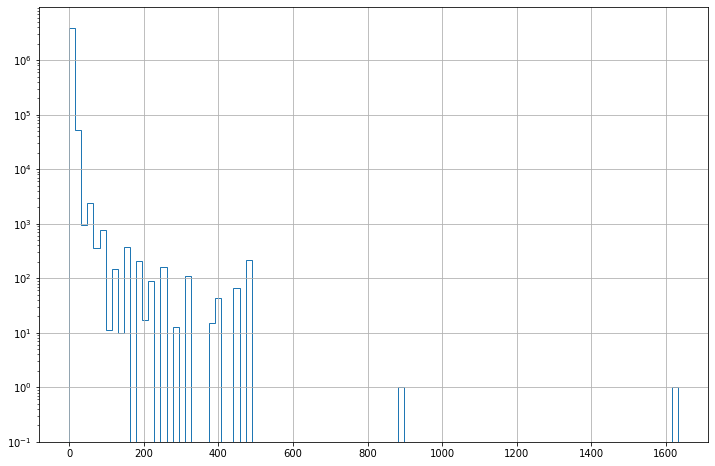

In [17]:
fg = plt.figure(figsize=(12,8))
ax1 = plt.subplot('111')
ax1.grid()
#
hh = ax1.hist(sacct_obj.jobs_summary['NCPUS'], log=True, bins=100, histtype='step')

In [18]:
print('** ', sacct_obj.jobs_summary['NCPUS'][0:10])

**  [1 1 1 1 1 1 1 1 1 1]


In [19]:
sacct_obj.__dict__.keys()

dict_keys(['data_file_name', 'delim', 'max_rows', 'types_dict', 'chunk_size', 'n_cpu', 'n_points_usage', 'max_chunksize', 'verbose', 'headers', 'RH', 'raw_data_len', 'data', 'index_job_id', 'ix_user_jobs', 'job_ID_index', 'k', 's', 'jobs_summary', 't_now', 'j_id', 'ks', 'sub_data', 'cpu_usage', 'weekly_hours', 'daily_hours'])

In [20]:
#sacct_obj.jobs_summary.dtype.names

#
#total_cpu = hpc_lib.elapsed_time_2_day(sacct_obj.jobs_summary['TotalCPU'])*24.
total_cpu = sacct_obj.jobs_summary['TotalCPU']*24.

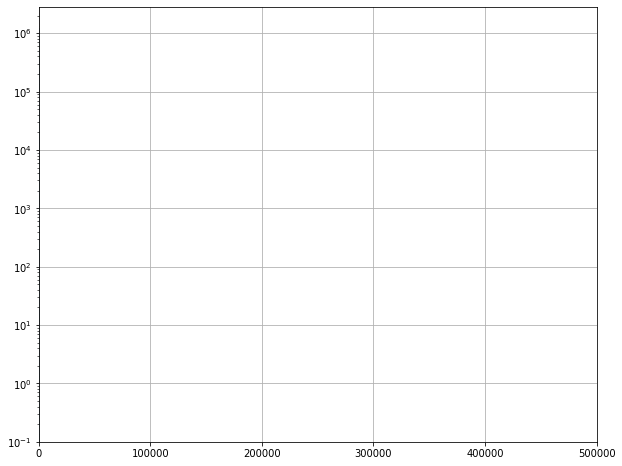

In [21]:
# sorted(total_cpu)[int(.8*len(total_cpu))]
#

fg = plt.figure(figsize=(10,8))
ax1=plt.subplot('111')
hh=ax1.hist(total_cpu[numpy.logical_and(total_cpu>0., total_cpu<sorted(total_cpu)[int(.9*len(total_cpu))])],
            bins=100, histtype='step', log=True, lw=2)

ax1.set_xlim(-10, 500000)
ax1.grid()


In [22]:
print('** ', total_cpu[0:20])

**  [48.00194444 47.995       0.06318917  0.          0.0632625  47.99527778
 47.99361111 47.99333333  0.06387111  0.06575972 47.99333333  0.06556611
 47.99138889 47.99222222 47.99166667  0.         47.96222222 47.99861111
 47.95972222 47.99333333]


In [23]:
# NOTE: It's pretty easy to get clock-plots for just the counts of something (here, pre-empted jobs),
#. but it's actually pretty messy to get distributions or statistics on those -- for example, to get the
#. mean and quantiles for N_preempted / dow, we have to define 2 indices: k1=k//k0, k2=k%k0,
#  then sum for all (j//k0==k1 and j%k0=k2) (all instances for each day, for each hour, so you
#. end up with a sequence that is 7*n_weeks for DoW or 24*n_days for HoD long). You can vectorize and do a
#. lot of loops, or you can sort and loop and pay the Python tax, or maybe PANDAS has a magic way?
#. but even then, this is specifically to get averaging over your modular time-scale, which is kind of
# arbitrary. A faster approach that is probably just as meaningful is to split into N subsets
#. and compute stats from those.
#
#ix_pr  = sacct_obj.jobs_summary['State']=='PREEMPTED'
def modulus_count_stats(X,a_mult=1., a_mod=1., qs=numpy.array([.5, .75, .95]),
                        n_samples=100, sample_size_fact=.3):
    '''
    # @X: X
    # a_mult, a_mod: X_prime = (X*a_mult)%a_mod
    # @qs: array of quantiles < 1.
    # @n_samples, @sample_size_fact: number and fractional size (n = N*sample_size_fact) for sampling
    #.   to generate statistics.
    '''
    #
    X_prime = ((numpy.array(X)*a_mult)%a_mod).astype(int)
    X_prime.sort()
    #
    # note: this will come back sorted.
    #X0 = numpy.unique(X_prime)
    #X0 = numpy.arange(min(X_prime), max(X_prime)+1).astype(int)
    X0 = numpy.arange(X_prime[0], X_prime[-1]+1)
    print('** X0', len(X0), ' ** ', X0)
    #
    #ix_random = numpy.random.shuffle(numpy.arange(0,len(X_prime)))
    #
    # first, get the counts for the full set.
    #
    counts = [numpy.sum( (X_prime==x).astype(int) ) for x in X0]
    #
    # in principle, this should be faster, but 1) it requires some debugging, 2) I'm not sure it will
    #. be much (if any) better after all the compiling, memory writes, etc. are taken into account.
    # also, .where() might not bet the 
#     counts = numpy.zeros(len(X0))
#     k1=0
#     for k, x in enumerate(X0):
#         ks = numpy.where(X_prime[k1:]==x)[0]
#         counts[k] = ks[-1] - ks[0] + 1 + k1
#         k1 = ks[-1]+1
    
    #
    # now, some quantiles and stats:
    #quantile_working_array = numpy.zeros( (len(X0), len(qs)+2) )
    k_s = numpy.ceil(sample_size_fact*len(X)).astype(int)
    #
    # use this factor to convert sampled  stats to the full value. this will be ~ sample_size_fact,
    #. but not exactly because of the ceil() operation
    sample_factor_actual = float(k_s)/float(len(X))
    #
    # do we explicityl shuffle X, or use a random integer index? The latter should be faster, but can 
    #. introduce artifacts from the random number generator.
    #working_array = numpy.array([X_prime[numpy.random.randint(0,len(X_prime), size=k_s)]
    #                             for _ in range(n_samples)])
    #
    working_array = numpy.array([[numpy.sum(XX==x) for x in X0]
                                 for XX in [X_prime[numpy.random.randint(0,len(X_prime), size=k_s)]
                                 for _ in range(n_samples)] ])/sample_factor_actual
    #
    # now take quantiles and stats along axis=0 of working_array.
    means = numpy.mean(working_array, axis=0)
    stdev = numpy.std(working_array, axis=0)
    #
    quantiles = numpy.quantile(working_array, q=qs, axis=0)
    #print('*** q-shape: ', quantiles.shape)
    #
    #print('*** shape: ', working_array.shape)
    #
    dtype = [('x', '<f8'), ('count', '<f8'), ('mean', '<f8'), ('stdev', '<f8')  ]
    for q in qs:
        dtype += [('q_{}'.format(q), '<f8')]
    output = numpy.zeros( (len(X0), ), dtype=dtype)
    #
    output['x'] = X0[:]
    output['count'] = counts[:]
    output['mean'] = means[:]
    output['stdev'] = stdev[:]
    #
    for k,(rw,q) in enumerate(zip(quantiles, qs)):
        #print('*** {}, {}'.format(k,q) )
        output['q_{}'.format(q)] = rw[:]
    #
    return output

In [42]:
#print('** ', preempted['NCPUS'][0:10])
ToD_end   = modulus_count_stats(X=preempted['End'], a_mult=24., a_mod=24., qs=[.25, .5, .75, .95])
ToD_sub   = modulus_count_stats(X=preempted['Submit'], a_mult=24., a_mod=24., qs=[.25, .5, .75, .95])
ToD_start = modulus_count_stats(X=preempted['Start'], a_mult=24., a_mod=24., qs=[.25, .5, .75, .95])
print('** shape(aa): ', aa.shape)
#
print('*** ', aa)
print('*** ', aa.dtype.names)

** X0 24  **  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
** X0 24  **  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
** X0 24  **  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
** shape(aa):  (24,)
***  [( 0., 2979., 2990.17537917, 102.87320756, 2909.14271305, 2986.64207493, 3057.47482503, 3184.14044874)
 ( 1., 2139., 2141.81569782,  81.51602784, 2095.81607657, 2146.64899135, 2204.14851791, 2264.14802388)
 ( 2., 1933., 1920.98418279,  82.2421881 , 1862.48466447, 1923.31749691, 1979.98369699, 2059.98303829)
 ( 3., 1918., 1905.85097406,  83.1432602 , 1868.31794977, 1904.98431453, 1959.98386167, 2023.81666941)
 ( 4., 1649., 1654.75304158,  68.93298335, 1601.6534788 , 1663.31963771, 1699.98600247, 1763.65214492)
 ( 5., 1313., 1317.68915027,  66.23085876, 1279.98946068, 1321.65578427, 1363.32210786, 1423.32161383)
 ( 6., 2063., 2059.88303911,  78.52529394, 2005.81681762, 2064.98299712, 2107.48264718, 2186

Text(0.5, 1.05, 'Preemptions by Hour')

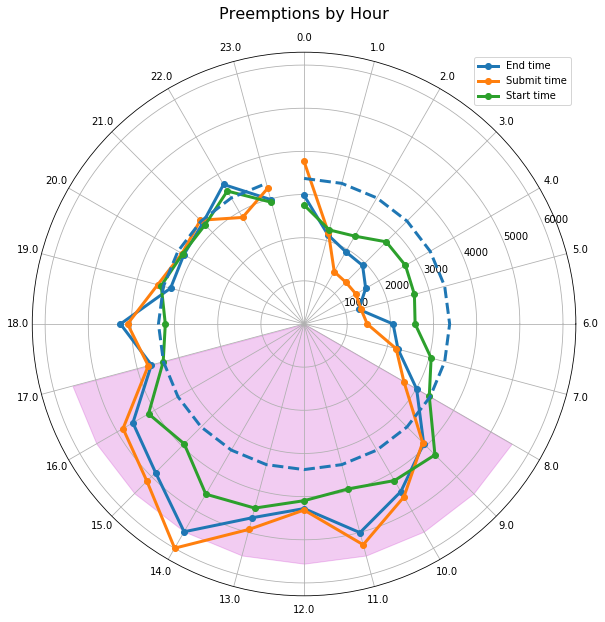

In [46]:
def x_to_clock(x):
    return ((6-x)%24)*rad_fact
fg = plt.figure(figsize=(12, 10))
ax = plt.subplot('111', projection='polar')
#
rad_fact = 2.0*scipy.constants.pi/24.
#
Thetas = scipy.constants.pi/2. - ToD_end['x']*rad_fact
#ax.plot(Thetas, ToD_end['mean'], ls='', marker='o', lw=3.)
ln,  = ax.plot(Thetas, ToD_end['count'], ls='-', marker='o', lw=3., label='End time')
ln2, = ax.plot(Thetas, ToD_sub['count'], ls='-', marker='o', lw=3., label='Submit time')
ln3, = ax.plot(Thetas, ToD_start['count'], ls='-', marker='o', lw=3., label='Start time')
#
#ax.plot(Thetas, ToD_end['count'], ls='', marker='o', lw=3.)
clr_end = ln.get_color()
clr_sub = ln2.get_color()
clr_start = ln3.get_color()
#
#ax.fill_between(Thetas, ToD_end['q_0.25'], ToD_end['q_0.75'], color=clr_end, alpha=.15)
ax.fill_between(x_to_clock(numpy.arange(8,18)), 0., max(aa['mean']), color='m', alpha=.2)
#
ax.plot(Thetas, numpy.ones(len(Thetas))*numpy.mean(ToD_end['count']), ls='--', 
        marker='', lw=3., color=clr_end)
# ax.plot(Thetas, numpy.ones(len(Thetas))*numpy.median(ToD_end['count']), ls='--', 
#         marker='', lw=3., label='median')
#
# ax.plot(Thetas, numpy.ones(len(Thetas))*numpy.mean(ToD_sub['count']), ls='--', 
#         marker='', lw=3., color=clr_sub)
# ax.plot(Thetas, numpy.ones(len(Thetas))*numpy.mean(ToD_start['count']), ls='--', 
#         marker='', lw=3., color=clr_start)
#
ax.set_xticks(ToD_end['x']*rad_fact)
ax.set_xticklabels( ((6. - aa['x'])%24) )
#ax.set_xticklabels( ((6. - aa['x'])%24)[::3])
#
ax.legend(loc=0)
ax.set_title('Preemptions by Hour', size=16)

# fg.canvas.draw() 
# plt.show() 

In [27]:
xx = numpy.random.random( (10,20))
print('** ', xx)

**  [[0.15047841 0.25294768 0.28431921 0.740587   0.72638386 0.94889146
  0.18849279 0.76709853 0.0857452  0.75672451 0.26382527 0.65660902
  0.67869393 0.76476967 0.54225007 0.75368896 0.70997381 0.25399536
  0.51098218 0.85592239]
 [0.37744894 0.2749676  0.12820845 0.97366153 0.79576461 0.46124404
  0.888588   0.20174849 0.34361829 0.48297312 0.15176312 0.97869398
  0.54101885 0.07871588 0.97816175 0.62934927 0.64522338 0.18711313
  0.01469082 0.03510545]
 [0.70994703 0.32716094 0.71325626 0.82742369 0.99990278 0.31563226
  0.42501395 0.28109869 0.6332123  0.71037198 0.32436406 0.60392478
  0.25524419 0.63439819 0.06357123 0.87695044 0.85359046 0.22503171
  0.80527293 0.54110824]
 [0.81982653 0.83159043 0.49850855 0.22935883 0.31687411 0.03660427
  0.5763845  0.08512241 0.43078162 0.60775699 0.58870229 0.12879859
  0.54940606 0.73122434 0.40250168 0.94085006 0.97330595 0.81306834
  0.2712393  0.66016509]
 [0.1121539  0.95998828 0.38942253 0.5412132  0.26612188 0.71720558
  0.90870988

In [28]:
qs = numpy.quantile(xx, q=[.5, .75, .95], axis=0)
print('** qs: ', qs)
print('shape: ', qs.shape)

** qs:  [[0.39189521 0.37530552 0.45238155 0.60309934 0.6088535  0.41094744
  0.4789352  0.39822041 0.42259115 0.62697748 0.29409467 0.44036256
  0.62497565 0.53135127 0.5634636  0.55292048 0.68085318 0.23951354
  0.40807523 0.43583862]
 [0.66354799 0.57419712 0.70171434 0.80571452 0.82600377 0.58959832
  0.58674315 0.49961159 0.59521116 0.70851059 0.39728639 0.64343796
  0.80242192 0.7070178  0.59793545 0.72260404 0.78758275 0.49265363
  0.48706466 0.67601887]
 [0.8589623  0.90220924 0.90604623 0.96888602 0.94170237 0.84463282
  0.89965504 0.709725   0.77521649 0.78346998 0.7545551  0.97922467
  0.86578681 0.77784699 0.92711632 0.91209523 0.91943398 0.74553006
  0.67616643 0.80229818]]
shape:  (3, 20)
